In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
myimages=["cablecar.bmp" , "cat evil hehe.jpg" , "image1.png"]

# DCT 

In [2]:

original_img = cv2.imread(myimages[1], 0)
print("original shape = "  ,  original_img.shape)


dct_img = cv2.dct(np.float32(original_img))
print("dct shape = "  ,  dct_img.shape)

dct_show = np.log(1+np.abs(dct_img))
print("dct_show shape = "  ,  dct_show.shape)

inverse_img = cv2.idct(dct_img).astype(np.uint8)
print("inverse shape = "  ,  inverse_img.shape)


original shape =  (476, 473)
dct shape =  (476, 473)
dct_show shape =  (476, 473)
inverse shape =  (476, 473)


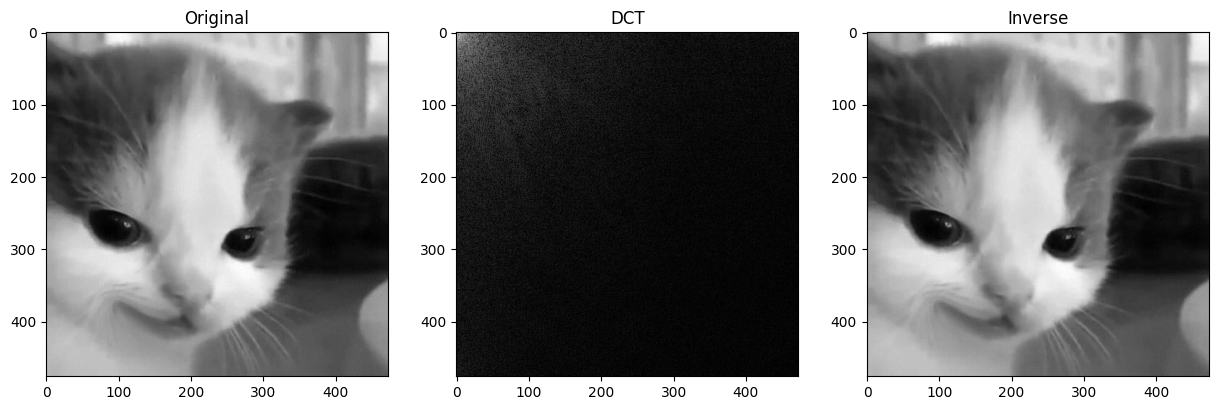

In [3]:
figure, plots = plt.subplots(1,3)
figure.set_figheight(15)
figure.set_figwidth(15)

plots[0].imshow(original_img, cmap='gray')
plots[0].set_title('Original')
plots[1].imshow(dct_show, cmap='gray')
plots[1].set_title('DCT')
plots[2].imshow(inverse_img, cmap='gray')
plots[2].set_title('Inverse')
plt.show()


## JPEG 
### Padding ,  DCT par bloc , Quantify DCT par bloc , Reconstruction

In [4]:

def padding(image):
    h , w = image.shape
    pad_rows , pad_cols = (0,0)
    if(h % 8 != 0):
        pad_rows = 8 - h % 8 
    if(w % 8 != 0):
        pad_cols = 8 - w % 8
    padded_image = np.pad(image , ((0,pad_rows) , (0 , pad_cols)) , 'constant').astype(np.float32)
    return padded_image

def dct_par_bloc(paddedimage):
    
    bloc_rows = int(paddedimage.shape[0] / 8) 
    bloc_cols = int(paddedimage.shape[1] / 8) 
    dct = np.empty_like(paddedimage , dtype=np.float32)
    
    for row in range(bloc_rows):
        rowstart = row * 8
        rowend = rowstart + (8 - 1)
        
        for col in range(bloc_cols):
            colstart = 8 * col
            colend = colstart + (8 - 1)
            
            blocimage = paddedimage[rowstart : rowend+1, colstart : colend+1]
            
            dct[rowstart : rowend+1 , colstart : colend+1] = cv2.dct(blocimage)

    return dct

def create_quantifactor (factor):
    return np.fromfunction(lambda i, j: 1+(1+i+j)*factor, (8,8) , dtype=np.uint8)  
  
def quantify_par_bloc(dct_image , qunatificator):
    
    bloc_rows = int(dct_image.shape[0] / 8) 
    bloc_cols = int(dct_image.shape[1] / 8) 
    
    dct_quantified = np.empty((dct_image.shape[0] , dct_image.shape[1]) , dtype=np.int32)
    
    for row in range(bloc_rows):
        rowstart = row * 8
        rowend = rowstart + (8 - 1)
        
        for col in range(bloc_cols):
            colstart = 8 * col
            colend = colstart + (8 - 1)
            blocimage = dct_image[rowstart : rowend+1, colstart : colend+1]
            dct_quantified[rowstart : rowend+1, colstart : colend+1] = blocimage // qunatificator
    
    return dct_quantified

def Reconstruire_par_bloc(dctquant , quantificator):
    
    bloc_rows = int(dctquant.shape[0] / 8) 
    bloc_cols = int(dctquant.shape[1] / 8) 
    
    reconstruite = np.empty((dctquant.shape[0] , dctquant.shape[1]) , dtype=np.int32)
    
    for row in range(bloc_rows):
        rowstart = row * 8
        rowend = rowstart + (8 - 1)
        
        for col in range(bloc_cols):
            colstart = 8 * col
            colend = colstart + (8 - 1)
            
            blocimage = dctquant[rowstart : rowend+1, colstart : colend+1]
            blocimage = blocimage * quantificator

            reconstruite [rowstart : rowend+1, colstart : colend+1]= cv2.idct(blocimage.astype(np.float32))
            
    return reconstruite
    

In [5]:
image = cv2.imread(myimages[1], 0)
print("image shape :" , image.shape , " , type :" , image.dtype)
padded_image = padding(image=image)
print("shape after padding :" , padded_image.shape  , " , type :" , padded_image.dtype) 

# DCT

dct_image = dct_par_bloc(padded_image)
dct_image_show = np.log(1+np.abs(dct_image))
print("dct shape :" , dct_image.shape , "type :" , dct_image.dtype)

# Quantification 
factor = 2
quantificator = create_quantifactor(factor)
print("\nQuantificateur de ", factor,"\n",quantificator)
dct_quantified = quantify_par_bloc(dct_image , quantificator)
print("\ndct_qunatified shape :" , dct_quantified.shape , "type :" , dct_quantified.dtype)

# Reconstruction 

reconstruire_img  = Reconstruire_par_bloc(dct_quantified , quantificator).astype(np.int64)
print("\nimage reconsuite shape :" , reconstruire_img.shape , "type :" , reconstruire_img.dtype)


np.savetxt("paddedimage.txt" , padded_image , fmt="%.d")
np.savetxt("dct.txt" , dct_image  , fmt="%.4f")
np.savetxt("dct_quantified.txt" , dct_quantified , fmt="%d")
np.savetxt("reconsuite.txt" , reconstruire_img , fmt="%d")




image shape : (476, 473)  , type : uint8
shape after padding : (480, 480)  , type : float32
dct shape : (480, 480) type : float32

Quantificateur de  2 
 [[ 3  5  7  9 11 13 15 17]
 [ 5  7  9 11 13 15 17 19]
 [ 7  9 11 13 15 17 19 21]
 [ 9 11 13 15 17 19 21 23]
 [11 13 15 17 19 21 23 25]
 [13 15 17 19 21 23 25 27]
 [15 17 19 21 23 25 27 29]
 [17 19 21 23 25 27 29 31]]

dct_qunatified shape : (480, 480) type : int32

image reconsuite shape : (480, 480) type : int64


### Affichage 

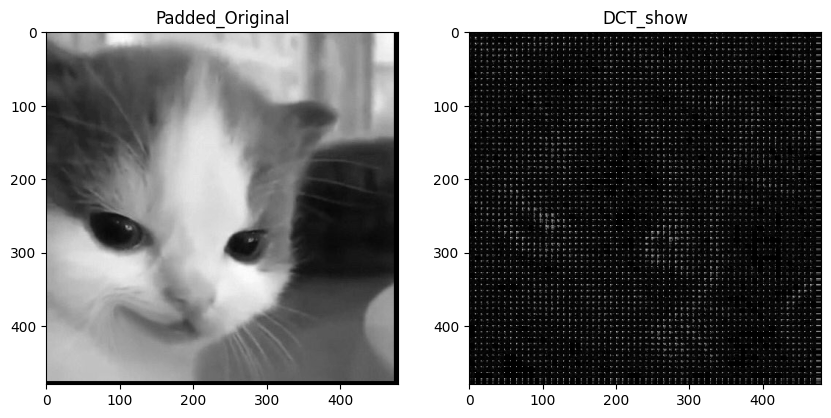

In [6]:
figure, plots = plt.subplots(1,2)
figure.set_figheight(10)
figure.set_figwidth(10)

plots[0].imshow(padded_image, cmap='gray')
plots[0].set_title('Padded_Original')
plots[1].imshow(dct_image_show, cmap='gray')
plots[1].set_title('DCT_show')


plt.show()

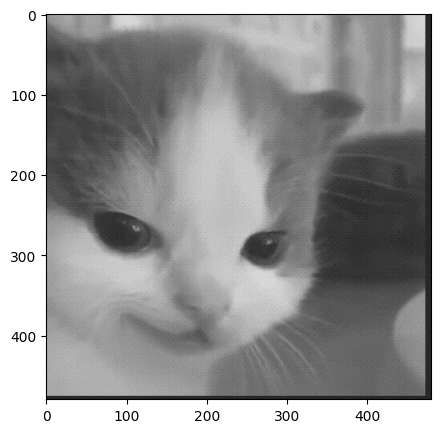

In [7]:
plt.figure(figsize= (5,5))
plt.imshow(reconstruire_img , cmap="gray")